In [105]:
import requests
import pandas as pd
import matplotlib.pyplot as plt

In [134]:
def load_funding_history_kraken(symbol):
  r = requests.get(f'https://futures.kraken.com/derivatives/api/v4/historicalfundingrates?symbol={symbol}')

  df = pd.DataFrame(r.json()['rates'])

  df.timestamp = pd.to_datetime(df.timestamp)
  df.set_index('timestamp', inplace=True)
  df.drop(['fundingRate'], axis=1, inplace=True)
  # df['fundingIntervalHours'] = 4
  df['lastFundingRate'] = df.relativeFundingRate * 4

  return df[::-1]


In [199]:
def load_funding_history_binance(symbol):

  def load_funding_history_page(symbol, page=1, rows=1000):
    r = requests.post(
      'https://www.binance.com/bapi/futures/v1/public/delivery/common/get-funding-rate-history',
      # 'https://www.binance.com/bapi/futures/v1/public/future/common/get-funding-rate-history', # COIN-M futures
      json={"symbol":symbol, "page":page,"rows":rows}
    )

    df= pd.DataFrame(r.json()['data'])
    df.calcTime = pd.to_datetime(df.calcTime, unit='ms', utc=True)
    df.lastFundingRate = pd.to_numeric(df.lastFundingRate) 
    df.set_index('calcTime', inplace=True)

    return df

  df = pd.concat(
    [load_funding_history_page(symbol), load_funding_history_page(symbol, page=2)]
  )

  return df

In [182]:
def show_stats(df):
  total_growth = df.lastFundingRate[::-1].sum()
  print(f'Total growth {total_growth * 100:.2f}%')
  print(f'From {df.index[-1]} to {df.index[0]}')

  fig, axs = plt.subplots(1, 2, figsize=(20, 4))

  growth = df.lastFundingRate[::-1].cumsum()
  axs[0].plot(growth * 100)
  axs[0].title.set_text('Growth, %')

  dd = growth - growth.cummax()
  axs[1].plot(dd * 100, c='r')
  axs[1].title.set_text('Drawdown, %')

  print(f'Max drawdown {-dd.min()}')



In [213]:
def compare_funding_stats(symbol):
  kraken_df = load_funding_history_kraken(f'PI_{symbol}')
  binance_df = load_funding_history_binance(f'{symbol}_PERP')

  print('Kraken (all history):')
  show_stats(kraken_df)

  print('\nKraken (relative history):')
  show_stats(kraken_df[kraken_df.index > binance_df.index.min()])

  print('\nBinance:')
  show_stats(binance_df)

Kraken (all history):
Total growth 18.48%
From 2018-08-31 16:00:00+00:00 to 2022-01-12 08:00:00+00:00
Max drawdown 0.4108299139555283

Kraken (relative history):
Total growth 24.04%
From 2020-09-08 12:00:00+00:00 to 2022-01-12 08:00:00+00:00
Max drawdown 0.0796719138757575

Binance:
Total growth 30.06%
From 2020-09-08 08:00:00.004000+00:00 to 2022-01-12 08:00:00+00:00
Max drawdown 0.010563189999999972


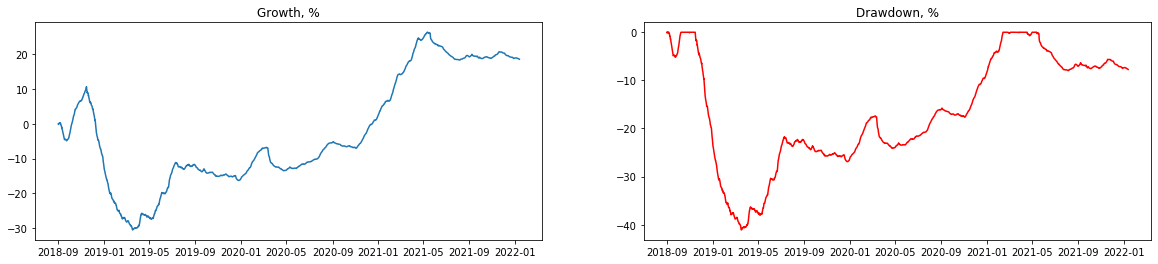

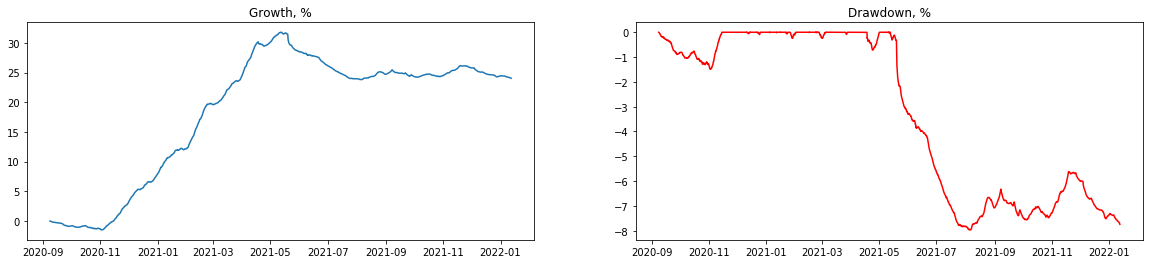

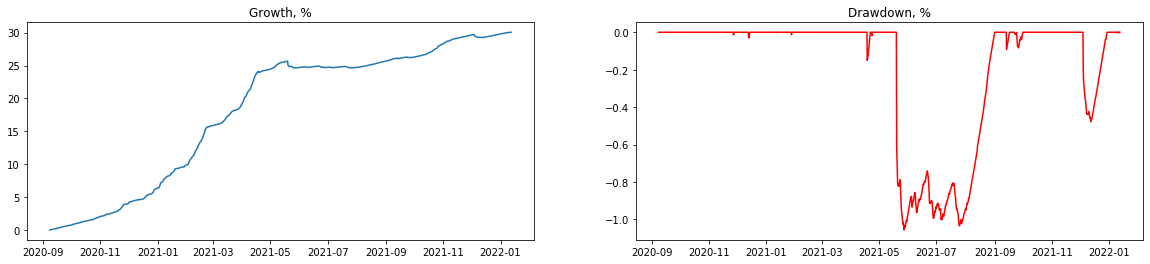

In [214]:
compare_funding_stats('LTCUSD')

Kraken (all history):
Total growth 61.82%
From 2018-08-31 16:00:00+00:00 to 2022-01-12 08:00:00+00:00
Max drawdown 0.19453669660394163

Kraken (relative history):
Total growth 39.44%
From 2020-08-18 12:00:00+00:00 to 2022-01-12 08:00:00+00:00
Max drawdown 0.01466058371250714

Binance:
Total growth 30.76%
From 2020-08-18 08:00:00+00:00 to 2022-01-12 08:00:00+00:00
Max drawdown 0.012789550000000009


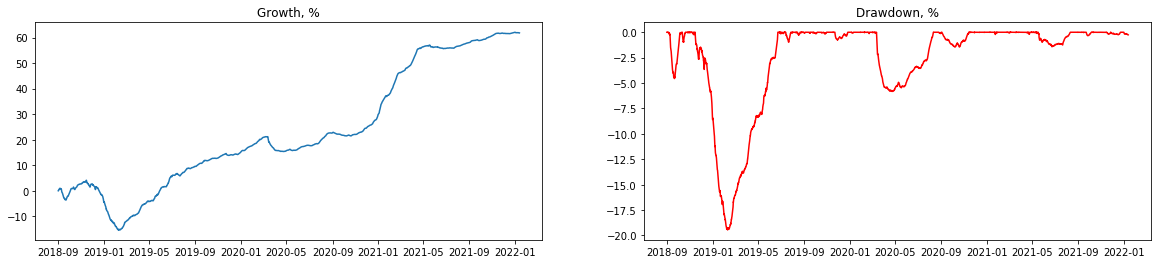

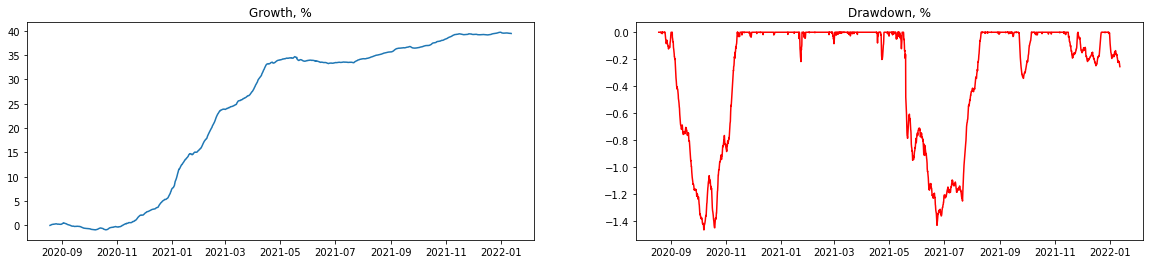

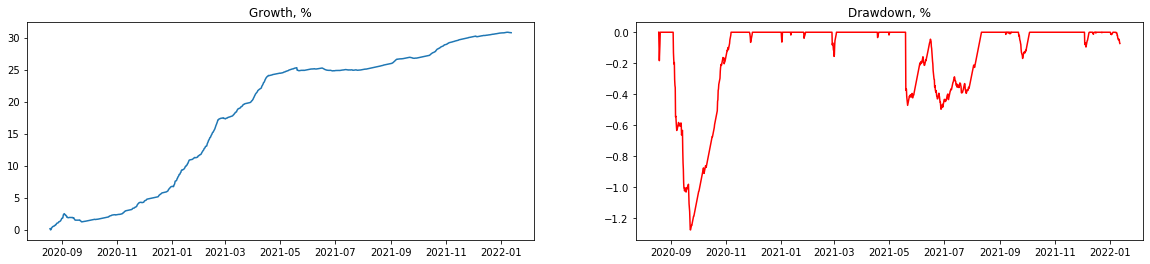

In [215]:
compare_funding_stats('ETHUSD')

Kraken (all history):
Total growth 53.79%
From 2018-08-31 16:00:00+00:00 to 2022-01-12 08:00:00+00:00
Max drawdown 0.340487532292855

Kraken (relative history):
Total growth 26.79%
From 2020-09-08 12:00:00+00:00 to 2022-01-12 08:00:00+00:00
Max drawdown 0.07132957450640498

Binance:
Total growth 26.71%
From 2020-09-08 08:00:00.004000+00:00 to 2022-01-12 08:00:00+00:00
Max drawdown 0.0055112799999999795


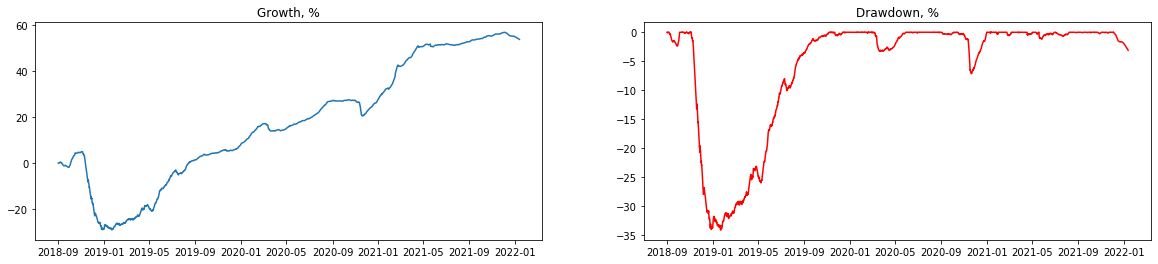

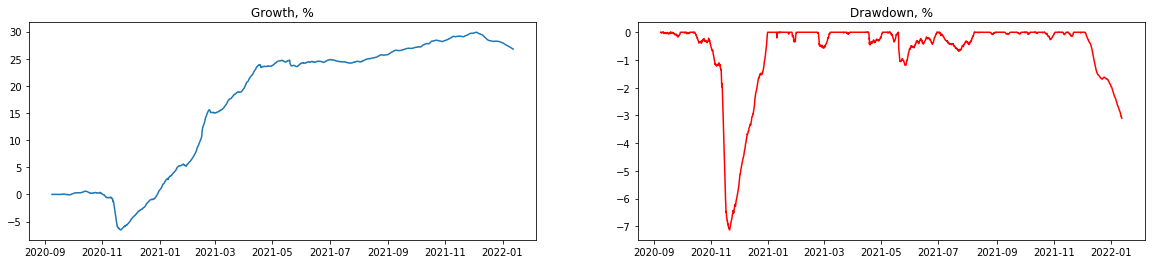

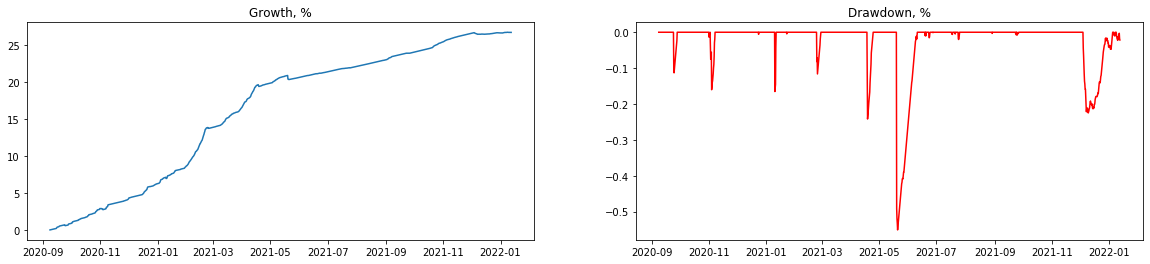

In [216]:
compare_funding_stats('BCHUSD')

In [ ]:
compare_funding_stats('XRPUSD')